In [1]:
# Carga del dataset
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

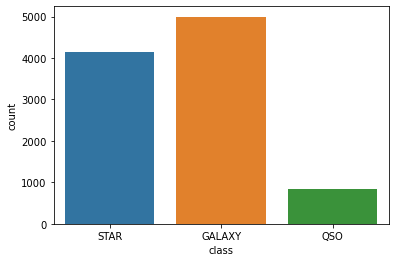

In [2]:
df = pd.read_csv("SDSS-DR14.csv")
class_values=df['class'].value_counts()

sns.countplot(x="class", data=df)
plt.show()

#Se aprecia un claro desbalanceo para los datos que corresponden a QSO.
#Este notebook implementará random over sampling y random under sampling para balancear las clases y comparar
#cual estilo de balanceo es mejor cuando se utiliza Regresión Logística, Árbol de Decisión y Random Forest.

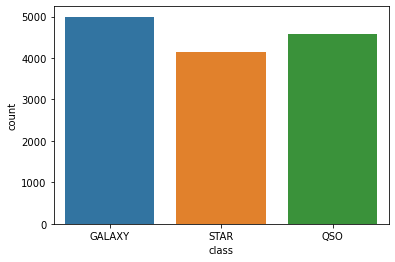

In [3]:
#Aplicamos random oversampling para elevar la cantidad de QSO y así balancear el dataset
df_galaxy = df[df['class']=='GALAXY']
df_star = df[df['class']=='STAR']
df_qso = df[df['class']=='QSO']

df_qso = df_qso.sample((class_values[0]+class_values[1])//2,replace=True)

df_over = pd.concat([df_galaxy, df_star, df_qso], axis=0)

sns.countplot(x="class", data=df_over)
plt.show()

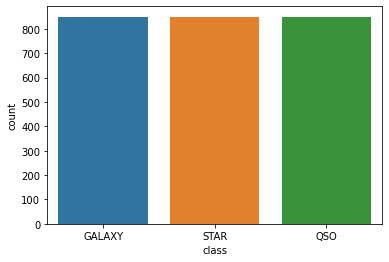

In [4]:
#Aplicamos random undersampling para disminuir la cantidad de GALAXY Y STAR y así balancear el dataset
df_galaxy = df[df['class']=='GALAXY']
df_star = df[df['class']=='STAR']
df_qso = df[df['class']=='QSO']

df_galaxy = df_galaxy.sample(class_values[2])
df_star = df_star.sample(class_values[2])

df_under = pd.concat([df_galaxy, df_star, df_qso], axis=0)


sns.countplot(x="class", data=df_under)
plt.show()

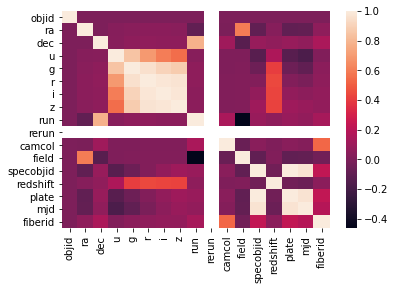

In [5]:
#Vemos la correlación que tienen los datos entre sí, eliminaremos todas menos una variable que tenga correlación
#entre sí, por ejemplo u,g,r,i,z eliminaremos todas menos 1, ya que u puede describir g,r,i,z.
#además rerun la eliminamos por completo ya que tiene correlación 1 con todas las variables.
#Las variables que indican un id, igualmente serán eliminadas ya que no aportan en nada a la clasificación
corr = df.corr()
sns.heatmap(corr, 
               xticklabels=corr.columns.values,
               yticklabels=corr.columns.values)

In [6]:
#Eliminaremos las variables que presentan una alta correlación entre sí(objid,g,r,i,z,rerun,specobid,mjd,fiberid)
df_over = df_over.drop(['objid','g','r','i','z','rerun','specobjid','mjd','fiberid'], 1)
df_under = df_under.drop(['objid','g','r','i','z','rerun','specobjid','mjd','fiberid'], 1)
df = df.drop(['objid','g','r','i','z','rerun','specobjid','mjd','fiberid'], 1)

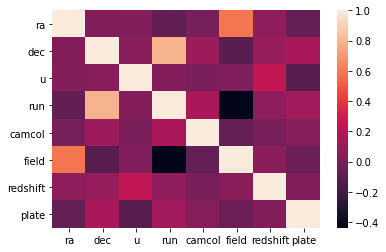

In [7]:
#vemos la correlación entre variables despues de eliminar columnas que no queríamos
corr = corr = df_over.corr()
sns.heatmap(corr, 
               xticklabels=corr.columns.values,
               yticklabels=corr.columns.values)

In [8]:
## Vemos cuales variables presentan una falta de datos
df_over.isnull().sum()

ra          0
dec         0
u           0
run         0
camcol      0
field       0
class       0
redshift    0
plate       0
dtype: int64

In [9]:
#Ahora creamos variables X e y para los datasets

#Oversampled
X_o = df_over.iloc[:,[0,1,2,3,4,5,7,8]]
y_o = df_over.iloc[:,6]

#Undersampled
X_u = df_under.iloc[:,[0,1,2,3,4,5,7,8]]
y_u = df_under.iloc[:,6]

#Data sin sample
X = df.iloc[:,[0,1,2,3,4,5,7,8]]
y = df.iloc[:,6]

#Separación de cada dataset en conjunto de entrenamiento y de testing

#Oversampled
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_o, y_o, test_size = .3, random_state=25)

#Undersampled
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_u, y_u, test_size = .3, random_state=25)

#Data sin sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [10]:
#Aplicamos regresion logística a cada dataset

#Oversampled
LogReg_o = LogisticRegression()
LogReg_o.fit(X_train_o, y_train_o)

#Undersampled
LogReg_u = LogisticRegression()
LogReg_u.fit(X_train_u, y_train_u)

#Sin sample
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)


/home/wrathion/anaconda3/envs/ia2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/wrathion/anaconda3/envs/ia2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/wrathion/anaconda3/envs/ia2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/wrathion/anaconda3/envs/ia2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/wrathion/anaconda3/envs/

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [11]:
#Predicciones para cada dataset
y_pred_o = LogReg_o.predict(X_test_o)#Oversampled

y_pred_u = LogReg_u.predict(X_test_u)#Undersampled

y_pred = LogReg.predict(X_test)#Sin sample


In [12]:
#Evaluación del rendimiento de RegLog para el dataset oversampled
confusion_matrix_log_o = confusion_matrix(y_test_o, y_pred_o)

print("Matriz de confusion para conjunto oversampled")
print(confusion_matrix_log_o)

print()
print("Recall y precision del conjunto oversampled")
print(classification_report(y_test_o, y_pred_o))

Matriz de confusion para conjunto oversampled
[[1489    3   31]
 [ 162 1199    9]
 [ 281    0  944]]

Recall y precision del conjunto oversampled
              precision    recall  f1-score   support

      GALAXY       0.77      0.98      0.86      1523
         QSO       1.00      0.88      0.93      1370
        STAR       0.96      0.77      0.85      1225

   micro avg       0.88      0.88      0.88      4118
   macro avg       0.91      0.87      0.88      4118
weighted avg       0.90      0.88      0.88      4118



In [13]:
#Evaluación del rendimiento de RegLog para el dataset undersampled
confusion_matrix_log_u = confusion_matrix(y_test_u, y_pred_u)

print("Matriz de confusion para conjunto undersampled")
print(confusion_matrix_log_u)

print()
print("Recall y precision del conjunto undersampled")
print(classification_report(y_test_u, y_pred_u))

Matriz de confusion para conjunto undersampled
[[259   1   3]
 [ 27 222   3]
 [ 52   0 198]]

Recall y precision del conjunto undersampled
              precision    recall  f1-score   support

      GALAXY       0.77      0.98      0.86       263
         QSO       1.00      0.88      0.93       252
        STAR       0.97      0.79      0.87       250

   micro avg       0.89      0.89      0.89       765
   macro avg       0.91      0.89      0.89       765
weighted avg       0.91      0.89      0.89       765



In [14]:
#Evaluación del rendimiento de RegLog para el dataset sin tener data sampleada
confusion_matrix_log = confusion_matrix(y_test, y_pred)

print("Matriz de confusion para conjunto undersampled")
print(confusion_matrix_log)

print()
print("Recall y precision del conjunto undersampled")
print(classification_report(y_test, y_pred))

Matriz de confusion para conjunto undersampled
[[1420    1   32]
 [  48  195    4]
 [ 322    0  978]]

Recall y precision del conjunto undersampled
              precision    recall  f1-score   support

      GALAXY       0.79      0.98      0.88      1453
         QSO       0.99      0.79      0.88       247
        STAR       0.96      0.75      0.85      1300

   micro avg       0.86      0.86      0.86      3000
   macro avg       0.92      0.84      0.87      3000
weighted avg       0.88      0.86      0.86      3000



#### Notamos básicamente que para regresión logística el recall de QSO (Cuando es oversampled) es mejor, y esto puede ser básicamente por que oversampled puede producir en muchos casos un sobreaprendizaje.
#### Cuando Galaxy y Star son undersampled, decaen su precisión y recall, no es algo exagerado pero se entiendo que es por que se pierden datos y puede que no aprenda correctamente a analizar.
#### Finalmente para la data que no fue sampleada (dataset desbalanceado) no existen muchas diferencias que indiquen que era 100% necesario balancear el dataset, con los "pocos" datos que existían de QSO se podía entrenar bien el modelo para que no hayan diferencias muy significativas.
#### Por lo tanto para Regresión logística la mejor opción era no balancear el dataset, dejar las muestras tal como se presentaban, y solamente eliminar columnas que no eran importantes.

In [15]:
#Entrenamiento Árboles de decisión

#Oversampled
clf_o = tree.DecisionTreeClassifier()
clf_o = clf_o.fit(X_train_o,y_train_o)

#Undersampled
clf_u = tree.DecisionTreeClassifier()
clf_u = clf_u.fit(X_train_u,y_train_u)

#Sin samplear
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

In [16]:
#Predicciones árboles de decisión

#Oversampled
y_pred_o = clf_o.predict(X_test_o)

#Undersampled
y_pred_u = clf_u.predict(X_test_u)

#Sin samplear
y_pred = clf.predict(X_test)

In [17]:
#Evaluación del rendimiento de árbol de decisión para data oversampled

confusion_matrix_tree_o = confusion_matrix(y_test_o, y_pred_o)

print()
print("Matriz de confusion árbol de decisión para data oversampled")
print(confusion_matrix_tree_o)

#Print de la matriz de confusión

print()
print("Recall y precision árbol de decisión para data oversampled")
print(classification_report(y_test_o, y_pred_o))


Matriz de confusion árbol de decisión para data oversampled
[[1498   25    0]
 [   3 1367    0]
 [   5    2 1218]]

Recall y precision árbol de decisión para data oversampled
              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.99      1523
         QSO       0.98      1.00      0.99      1370
        STAR       1.00      0.99      1.00      1225

   micro avg       0.99      0.99      0.99      4118
   macro avg       0.99      0.99      0.99      4118
weighted avg       0.99      0.99      0.99      4118



In [18]:
#Evaluación del rendimiento árbol de decisión para data undersampled

confusion_matrix_tree_u = confusion_matrix(y_test_u, y_pred_u)

print()
print("Matriz de confusion árbol de decisión para data undersampled")
print(confusion_matrix_tree_u)

#Print de la matriz de confusión

print()
print("Recall y precision árbol de decisión para data undersampled")
print(classification_report(y_test_u, y_pred_u))


Matriz de confusion árbol de decisión para data undersampled
[[244  18   1]
 [ 11 241   0]
 [  1   0 249]]

Recall y precision árbol de decisión para data undersampled
              precision    recall  f1-score   support

      GALAXY       0.95      0.93      0.94       263
         QSO       0.93      0.96      0.94       252
        STAR       1.00      1.00      1.00       250

   micro avg       0.96      0.96      0.96       765
   macro avg       0.96      0.96      0.96       765
weighted avg       0.96      0.96      0.96       765



In [19]:
#Evaluación del rendimiento árbol de decisión para data sin samplear

confusion_matrix_tree = confusion_matrix(y_test, y_pred)

print()
print("Matriz de confusion árbol de decisión para data sin samplear")
print(confusion_matrix_tree)

#Print de la matriz de confusión

print()
print("Recall y precision árbol de decisión para data sin samplear")
print(classification_report(y_test, y_pred))


Matriz de confusion árbol de decisión para data sin samplear
[[1434   17    2]
 [  30  217    0]
 [   8    2 1290]]

Recall y precision árbol de decisión para data sin samplear
              precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98      1453
         QSO       0.92      0.88      0.90       247
        STAR       1.00      0.99      1.00      1300

   micro avg       0.98      0.98      0.98      3000
   macro avg       0.96      0.95      0.96      3000
weighted avg       0.98      0.98      0.98      3000



#### Aquí no hay duda que para el árbol de decisión la mejor opción fue balancear el árbol aumentando el número de QSO a un promedio de muestras entre STAR y GALAXY, ya que se observa que el primer resultado predice con exactitud las clases STAR y GALAXY, las cuales no fueron alteradas, mientras que la que fue alterada (QSO), se comportó de mejor manera que los otros dos resultados. Así que para Árbol de decisión era buena práctica balancear el dataset a favor de las dos variables más grandes.

In [20]:
#Entrenamiento Random Forest

#Oversampled
classifier_o = RandomForestClassifier(n_estimators = 15, criterion = 'entropy', random_state = 95)
classifier_o.fit(X_train_o, y_train_o)

#UnderSampled
classifier_u = RandomForestClassifier(n_estimators = 15, criterion = 'entropy', random_state = 95)
classifier_u.fit(X_train_u, y_train_u)

#Sin samplear
classifier = RandomForestClassifier(n_estimators = 15, criterion = 'entropy', random_state = 95)
classifier.fit(X_train, y_train)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
            oob_score=False, random_state=95, verbose=0, warm_start=False)

In [21]:
#Predicciones Random Forest

#Oversampled
y_pred_o = classifier_o.predict(X_test_o)

#Undersampled
y_pred_u = classifier_u.predict(X_test_u)

#Sin samplear
y_pred = classifier.predict(X_test)

In [22]:
#Evaluación del rendimiento de Random Forest oversampled
confusion_matrix_log_o = confusion_matrix(y_test_o, y_pred_o)

print()
print("Matriz de confusion de Random Forest oversampled")
print(confusion_matrix_log_o)

print()
print("Recall y precision de Random Forest oversampled")
print(classification_report(y_test_o, y_pred_o))


Matriz de confusion de Random Forest oversampled
[[1506   11    6]
 [   0 1370    0]
 [   3    0 1222]]

Recall y precision de Random Forest oversampled
              precision    recall  f1-score   support

      GALAXY       1.00      0.99      0.99      1523
         QSO       0.99      1.00      1.00      1370
        STAR       1.00      1.00      1.00      1225

   micro avg       1.00      1.00      1.00      4118
   macro avg       1.00      1.00      1.00      4118
weighted avg       1.00      1.00      1.00      4118



In [23]:
#Evaluación del rendimiento de Random Forest undersampled
confusion_matrix_log_u = confusion_matrix(y_test_u, y_pred_u)

print()
print("Matriz de confusion de Random Forest undersampled")
print(confusion_matrix_log_u)

print()
print("Recall y precision de Random Forest undersampled")
print(classification_report(y_test_u, y_pred_u))


Matriz de confusion de Random Forest undersampled
[[258   4   1]
 [ 14 238   0]
 [  0   0 250]]

Recall y precision de Random Forest undersampled
              precision    recall  f1-score   support

      GALAXY       0.95      0.98      0.96       263
         QSO       0.98      0.94      0.96       252
        STAR       1.00      1.00      1.00       250

   micro avg       0.98      0.98      0.98       765
   macro avg       0.98      0.98      0.98       765
weighted avg       0.98      0.98      0.98       765



In [24]:
#Evaluación del rendimiento de Random Forest sin samplear
confusion_matrix_log = confusion_matrix(y_test, y_pred)

print()
print("Matriz de confusion de Random Forest sin samplear")
print(confusion_matrix_log)

print()
print("Recall y precision de Random Forest sin samplear")
print(classification_report(y_test, y_pred))


Matriz de confusion de Random Forest sin samplear
[[1444    6    3]
 [  28  219    0]
 [   5    0 1295]]

Recall y precision de Random Forest sin samplear
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.99      1453
         QSO       0.97      0.89      0.93       247
        STAR       1.00      1.00      1.00      1300

   micro avg       0.99      0.99      0.99      3000
   macro avg       0.98      0.96      0.97      3000
weighted avg       0.99      0.99      0.99      3000



#### Para Random Forest, ocurre exactamente lo mismo que para Árbol de decisión, la mejor opción fue balancear el dataset a favor de STAR y GALAXY, elevando el número de muestras de QSO. Cuando hacemos esto, se puede predecir de manera correcta STAR y GALAXY, sin haber sido modificados sus datos, mientras que QSO tiene el mejor rendimiento con respecto a los otros dos datasets(undersampled y sin samplear).

## Ventajas Regresión Logística
Funciona de buena manera aunque los datos no esten balanceados, es fácil de implementar, funciona con multiclases y clases binarias, no requiere escalamientos
## Desventajas Regresión Logística
No tiene un buen performance con respecto a otros algoritmos para clasificar

## Ventajas Árbol de decisión
Tiene un muy buen performance en general (teniendo datos oversampleds, undersampleds, y dataset desbalanceado), no requiere escalamientos
## Desventajas Árbol de decisión
Solo crea un árbol para predecir, lo que puede crear fallas a nuevos datos, dificil de entender a simple vista si no conoces del tema.

## Ventajas Random Forest
Tiene el mejor performance en general, no requiere escalamientos, al crear muchos árboles de decisión, puede responder de mucha mejor manera que un solo árbol de decisión, es más exacto, menos errores.
## Desventajas Random Forest
Puede producir un sobre ajuste de manera muy sencilla, toma mucho más tiempo que cualquier otro método presentado, demora más en entrenar, depende de una máquina de buenas características para tener buenos resultados en el modelo. 

## Finalmente los mejores datos para predecir el modelo son los que utilizamos, ya que obtuvimos muy buenos resultados con los datos que dejamos del dataset.
ra, dec, u, run , camcol, field, redshift y plate.